# Temporal difference control on GridWorld game

In [66]:
#convergence
#mapa con flechas indicando mejor accion en cada celda

### Import libraries

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import time
%matplotlib notebook

### Create GridMap class

In [29]:
class GridMap:
    def __init__(self, w, h):
        self.w = w
        self.h = h
        
        self.cliffRwd = -100
        self.gridRwd  = -1
        
        self.start = [0,   0]
        self.end   = [w-1, 0]
    
    @property
    def grid(self):
        out = np.ones([self.h, self.w]) * self.gridRwd
        out[0,1:-1] = self.cliffRwd
        return out  

### Support functions

In [67]:
%matplotlib notebook

def plotGrid(GridWorld):
    ''' Plot empty grid map with grass and cliff. '''
    
    cmap   = colors.ListedColormap(['pink', 'lightgray'])
    bounds = [GridWorld.cliffRwd, GridWorld.gridRwd ,0]
    norm   = colors.BoundaryNorm(bounds, cmap.N)

    fig, ax = plt.subplots(figsize = (8,4))
    ax.imshow(GridWorld.grid, cmap=cmap, norm=norm)

    # draw gridlines
    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
    ax.set_xticks(np.arange(0.5, GridWorld.w, 1));
    ax.set_yticks(np.arange(0.5, GridWorld.h, 1));

    # hide axes labels
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # plot start & end
    plt.text(GridWorld.start[0]-0.4, GridWorld.start[1]+0.1, 'START', fontsize=10)
    plt.text(GridWorld.end[0]-0.25,   GridWorld.end[1] +0.1,   'END', fontsize=10)
    
    return([fig,ax])
    
    
def moveAgent(state, GridObj, a):
    ''' Get agent's next state based on current state and given action. 
    If the agent tries to move outside the boundaries of the gridmap, 
    # it will remain in the same position. '''
    
    nextState = state.copy()
    if   a == 'UP':    nextState[1] = max(state[1] - 1, 0)
    elif a == 'RIGHT': nextState[0] = min(state[0] + 1, GridObj.w - 1) 
    elif a == 'DOWN':  nextState[1] = min(state[1] + 1, GridObj.h - 1) 
    else:              nextState[0] = max(state[0] - 1, 0)   
    return(nextState)


def selectAction(Q, actions, eps = 0.1):
    ''' Select action with epsilon-greedy policy. '''
    
    thresh = np.random.uniform()        
    
    if thresh > eps:
        action = actions[np.argmax(Q[:, agentPos[1], agentPos[0]])] # Select greedy action
    else:
        action = random.choice(actions) # Select random action        
    return(action)


def progress(acValFun, acs, eps, state, gridObj):
    '''Update action, next state and reward. '''
    
    # Select action for behaviour, move agent according to selected action
    ac     = selectAction(acValFun, acs, eps)
    
    # Terminating state returns to itself with reward 0
    if state != gridObj.end:
        nextSt = moveAgent(state, gridObj, ac)
        reward = gridObj.grid[nextSt[1], nextSt[0]]
    else:
        nextSt = state.copy()
        reward = 0.0
    acIdx  = int(np.argwhere(acs == ac))    
    return([ac, nextSt, reward, acIdx])


def updateOnline(Q, a, s, alph, R, a_tilde, s_tilde, mode):
    ''' Backup action-value function of explored state according 
    to algorithm selected. '''
    
    if   mode == 'sarsa':
        Q[a, s[1], s[0]] = (1 - alph) * Q[a, s[1], s[0]] + alph * (R + Q[a_tilde, s_tilde[1], s_tilde[0]])
    elif mode == 'qlearning':
        Q[a, s[1], s[0]] = (1 - alph) * Q[a, s[1], s[0]] + alph * (R + max(Q[:, s_tilde[1], s_tilde[0]]))    
    return(Q)


def selectEpisode(plotInt, episode):
    ''' Determine whether this episode should be plotted. '''
    
    cond1 = round(episode/plotInt) == episode/plotInt
    cond2 = episode in [5,15]
    return(cond1 or cond2)


def plotAgent(ax, agentPos, sleep=0.1):  
    ''' Update agent position on gridmap and update plot. '''
    
    if ax.lines:
        for line in ax.lines:
            line.set_xdata(agentPos[0])
            line.set_ydata(agentPos[1])
    else:
        marker = 'ko'
        ms = 25
        ax.plot(agentPos[0], agentPos[1], marker, ms=ms)
    
    fig.canvas.draw()
    time.sleep(sleep)

### Implement SARSA/Q-learning

<IPython.core.display.Javascript object>


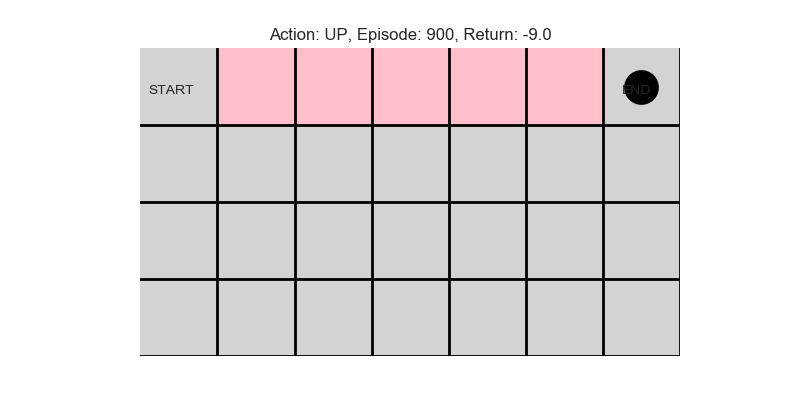

In [68]:
%matplotlib notebook

mode    = 'qlearning'

# Initialise grid map object and plot empty grid
GridWorld = GridMap(7,4)
[fig, ax] = plotGrid(GridWorld)

# Create list of actions
actions = np.array(['UP', 'RIGHT', 'DOWN', 'LEFT'])

# Initialise Q function, learning rate
Q       = np.zeros([4, GridWorld.h, GridWorld.w])
alpha   = 0.2
plotInt = 100
maxIter = 1000
eps     = 0.1
sleep   = 0.05

 
# Execute SARSA control algorithm

for episode in range(maxIter):

    # initialise agent position, plot initial position
    agentPos = (GridWorld.start).copy()
    
    # Determine whether this episode should be plotted
    plotThisEp = selectEpisode(plotInt, episode)
    
    # Plot every fixed number of episodes
    if plotThisEp: plotAgent(ax, agentPos)

    # Initialise step, return
    t       = 0
    return_ = 0
    prevState = GridWorld.start
    
    while prevState != GridWorld.end:
        
        # Select action for behaviour, move agent according to selected action
        [action, nextAgPos, Rwd, aIdx] = progress(Q, actions, eps, agentPos, GridWorld)
        return_ += Rwd
        
        # Backup
        if t > 0:    
            Q = updateOnline(Q, prevAIdx, prevState, alpha, prevRwd, aIdx, agentPos,mode)
        
        # Logical value, true if agent fell off the cliff
        cliffFlag = GridWorld.grid[nextAgPos[1], nextAgPos[0]] == GridWorld.cliffRwd

        # Refresh agent position on the plotted gridmap, update plot title
        if plotThisEp:
            plotAgent(ax, nextAgPos, sleep=sleep) 
            plt.title('Action: ' + action + ", Episode: " + str(episode) + ", Return: " + str(return_))

        # if agent falls in a cliff cell, stop episode but update action value function
        if cliffFlag: 
            Q[aIdx, agentPos[1], agentPos[0]] = (1-alpha) * Q[aIdx, agentPos[1], agentPos[0]] + alpha*(Rwd+0)
            break

        # Store previous values for next update
        prevRwd       = Rwd
        prevState     = agentPos.copy()
        prevAIdx      = aIdx
        agentPos      = nextAgPos.copy()

        t += 1

### Plot heatmap of action value function of each action

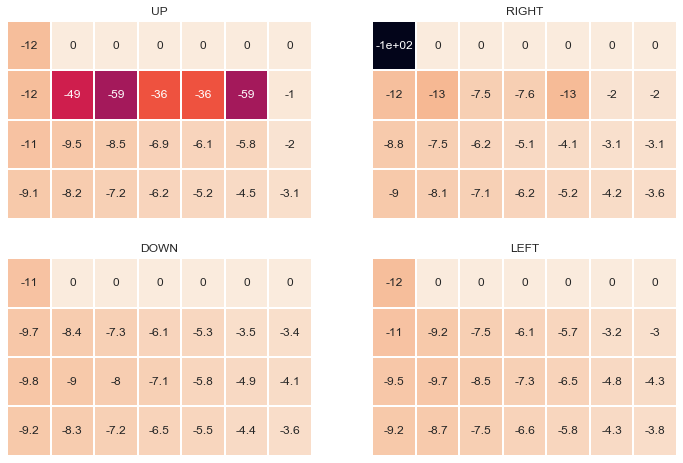

In [56]:
%matplotlib inline
import seaborn as sns; sns.set()
fig, ax = plt.subplots(2,2, figsize = (12,8))

for i in range(2):
    for j in range(2):
        sns.heatmap(Q[2*i+j,:,:], ax=ax[i,j], vmax=0, vmin=-100, cbar=False, 
                    linewidths=1, annot=True, xticklabels=False, yticklabels=False)
        ax[i,j].set_title(actions[2*i+j])    